<a href="https://colab.research.google.com/github/selcukkanun/DSA210-F1-LOGISTICS/blob/main/Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hypothesis Testing
 Null Hypothesis (H₀): Being World Driver Champion (WDC) has no effect on how much they outperform their teammate.

Alternative Hypothesis (H₁): Being a WDC means outperforming your teammates more across the career.

Sub Question for hypothesis: Being more WDC means outperforming your teammates more across the career. (more championship more outperforming)

Alternative Hypothesis No.2 (H₂): Champion drivers perform better in wet conditions than non-champions, and more championships correlates with more win-rate in wet races.


#Coding Part:

Cross checked list of wet races and driver championship dictionary at the beginning.

In [168]:
true_wet_races = {
    1985: ["Portuguese Grand Prix", "Belgian Grand Prix"],
    1986: [],
    1987: [],
    1988: ["British Grand Prix", "German Grand Prix", "Japanese Grand Prix"],
    1989: ["Canadian Grand Prix", "Belgian Grand Prix", "Australian Grand Prix"],
    1990: ["Canadian Grand Prix"],
    1991: ["Brazilian Grand Prix", "San Marino Grand Prix", "Spanish Grand Prix", "Australian Grand Prix"],
    1992: ["Spanish Grand Prix", "French Grand Prix", "Belgian Grand Prix"],
    1993: ["Brazilian Grand Prix", "European Grand Prix", "San Marino Grand Prix", "Japanese Grand Prix"],
    1994: ["Japanese Grand Prix"],
    1995: ["Argentine Grand Prix", "San Marino Grand Prix", "Belgian Grand Prix", "European Grand Prix", "Japanese Grand Prix"],
    1996: ["Brazilian Grand Prix", "Monaco Grand Prix", "Spanish Grand Prix"],
    1997: ["Monaco Grand Prix", "French Grand Prix", "Belgian Grand Prix"],
    1998: ["Argentine Grand Prix", "British Grand Prix", "Belgian Grand Prix"],
    1999: ["French Grand Prix", "European Grand Prix"],
    2000: ["European Grand Prix", "Canadian Grand Prix", "German Grand Prix", "Belgian Grand Prix",
           "United States Grand Prix", "Japanese Grand Prix"],
    2001: ["Malaysian Grand Prix", "Brazilian Grand Prix"],
    2002: ["British Grand Prix"],
    2003: ["Brazilian Grand Prix", "United States Grand Prix"],
    2004: ["Malaysian Grand Prix", "Italian Grand Prix", "Brazilian Grand Prix"],
    2005: ["Belgian Grand Prix"],
    2006: ["Hungarian Grand Prix", "Chinese Grand Prix"],
    2007: ["European Grand Prix", "Japanese Grand Prix", "Chinese Grand Prix"],
    2008: ["Monaco Grand Prix", "British Grand Prix", "Belgian Grand Prix", "Italian Grand Prix", "Brazilian Grand Prix"],
    2009: ["Malaysian Grand Prix", "Chinese Grand Prix"],
    2010: ["Australian Grand Prix", "Chinese Grand Prix", "Belgian Grand Prix", "Korean Grand Prix"],
    2011: ["Canadian Grand Prix", "British Grand Prix", "Hungarian Grand Prix"],
    2012: ["Malaysian Grand Prix", "Brazilian Grand Prix"],
    2013: ["European Grand Prix"],
    2014: ["Hungarian Grand Prix", "Japanese Grand Prix"],
    2015: ["British Grand Prix", "United States Grand Prix"],
    2016: ["Monaco Grand Prix", "British Grand Prix", "Brazilian Grand Prix"],
    2017: ["Chinese Grand Prix", "Singapore Grand Prix"],
    2018: ["German Grand Prix"],
    2019: ["German Grand Prix"],
    2020: ["Turkish Grand Prix"],
    2021: ["Emilia Romagna Grand Prix", "Russian Grand Prix", "Turkish Grand Prix"],
    2022: ["Emilia Romagna Grand Prix", "Monaco Grand Prix", "Singapore Grand Prix", "Japanese Grand Prix"],
    2023: ["Monaco Grand Prix", "Dutch Grand Prix"],
    2024: ["Canadian Grand Prix", "British Grand Prix", "Brazilian Grand Prix"]
}


In [169]:
world_champions_1985_2024 = {
    "Alain Prost": 3,
    "Ayrton Senna": 4,
    "Nigel Mansell": 1,
    "Michael Schumacher": 7,
    "Mika Hakkinen": 2,
    "Damon Hill": 1,
    "Jacques Villeneuve": 1,
    "Fernando Alonso": 2,
    "Kimi Raikkonen": 1,
    "Jenson Button": 1,
    "Sebastian Vettel": 4,
    "Lewis Hamilton": 7,
    "Nico Rosberg": 1,
    "Max Verstappen": 4
}


**Merging races between 1985 to 2024 with their wet race data:**

In [170]:
import pandas as pd

races = pd.read_csv("races.csv")

races = races[(races["year"] >= 1985) & (races["year"] <= 2024)]

# Add wet indicator
def is_true_wet(row):
    return row["name"] in true_wet_races.get(row["year"], [])

races["is_true_wet"] = races.apply(is_true_wet, axis=1)

# Save
races_with_wettag = "races_with_wettag.csv"
races.to_csv(races_with_wettag, index=False)


**Merging all of the races and their result with driver name constructor name and championship data:**

In [171]:
import pandas as pd

# Load datasets
races = pd.read_csv("races_with_wettag.csv")
results = pd.read_csv("results.csv")
drivers = pd.read_csv("drivers.csv")
constructors = pd.read_csv("constructors.csv")
status = pd.read_csv("status.csv")   # NEW

# Merge statusId -> status text
results = results.merge(
    status[["statusId", "status"]],
    on="statusId",
    how="left"
)

# Merge results with race info
merged = results.merge(
    races[["raceId", "year", "name", "is_true_wet"]],
    on="raceId",
    how="inner"
)

# Add driver names
merged = merged.merge(
    drivers[["driverId","forename","surname"]],
    on="driverId",
    how="left"
)

# Add constructor names
merged = merged.merge(
    constructors[["constructorId","name"]].rename(columns={"name":"constructorName"}),
    on="constructorId",
    how="left"
)

# Keep final desired columns (now status exists!)
merged = merged[[
    "raceId", "year", "name",
    "driverId", "forename", "surname",
    "constructorId", "constructorName",
    "positionText", "status",
    "is_true_wet"
]]

# Save final dataset
driver_finishin_position = "driver_finishing_positions.csv"
merged.to_csv(driver_finishin_position, index=False)


In [172]:
import pandas as pd

df = pd.read_csv("driver_finishing_positions.csv")


df["position"] = pd.to_numeric(df["positionText"], errors="coerce")
df = df.dropna(subset=["position"])

df["finished_flag"] = df["status"].apply(lambda x: 1 if x == "Finished" else 0)

df = df[[
    "raceId","year","driverId","forename","surname","constructorId","constructorName","position","finished_flag"
]]

teammate_pairs = []

rows = []

for (raceId, constructorId), group in df.groupby(["raceId", "constructorId"]):

    # Leaving out the times where one of each driver hasn't raced for any reason
    if len(group) != 2:
        continue

    d1 = group.iloc[0]
    d2 = group.iloc[1]

    f1 = d1["finished_flag"]
    f2 = d2["finished_flag"]

    # Case 1: both DNF then skip no one beat the other
    if f1 == 0 and f2 == 0:
        continue

    # Case 2: only first driver finished
    if f1 == 1 and f2 == 0:
        rows.append([d1, d2, 1])
        rows.append([d2, d1, 0])
        continue

    # Case 3: only second driver finished
    if f1 == 0 and f2 == 1:
        rows.append([d1, d2, 0])
        rows.append([d2, d1, 1])
        continue

    # Case 4: if both finish then compare positions
    if d1["position"] < d2["position"]:
        rows.append([d1, d2, 1])
        rows.append([d2, d1, 0])
    else:
        rows.append([d1, d2, 0])
        rows.append([d2, d1, 1])

clean_rows = []

for dA, dB, beatA in rows:
    clean_rows.append({
        "driverId": dA["driverId"],
        "forename": dA["forename"],
        "surname": dA["surname"],
        "constructorId": dA["constructorId"],
        "constructorName": dA["constructorName"],
        "raceId": dA["raceId"],
        "year": dA["year"],
        "beat_teammate": beatA
    })

rel = pd.DataFrame(clean_rows)


result = rel.groupby(
    ["driverId","forename","surname"]
).agg(
    total_races=("beat_teammate","count"),
    beat_count=("beat_teammate","sum")
).reset_index()

result["beating_rate"] = result["beat_count"] / result["total_races"]

# Apply minimum 5 teammate races filter
result_filtered = result[result["total_races"] >= 5].copy()

# Save
result.to_csv("clean_teammate_beating_rate.csv", index=False)

In [173]:
import pandas as pd
from scipy.stats import mannwhitneyu, pearsonr, spearmanr

df = pd.read_csv("clean_teammate_beating_rate.csv")

df = df[df["total_races"] >= 5]

df["full_name"] = df["forename"] + " " + df["surname"]

n = len(df_f)
df_deg = n - 2

# Add wc_count column
df["wc_count"] = df["full_name"].apply(lambda x: world_champions_1985_2024.get(x, 0))

champions = df_f[df_f["wc_count"] > 0]["beating_rate"]
non_champions = df_f[df_f["wc_count"] == 0]["beating_rate"]

#Mann–Whitney U-test (non-parametric, correct for distributions)
U, p_mw = mannwhitneyu(champions, non_champions, alternative="two-sided")

print("\n Mann–Whitney U-Test (Beating Rate)")
print("U statistic:", U)
print("p-value:", f"{p_mw:.9f}")


# Spearman
spearman_corr, spearman_p = spearmanr(df_f["wc_count"], df_f["beating_rate"])
print("\n Spearman Correlation")
print(f"Correlation: {spearman_corr:.4f}")
print(f"p-value: {spearman_p:.9f}")
print(f"df = {df_deg}")


 Mann–Whitney U-Test (Beating Rate)
U statistic: 937.5
p-value: 0.000005033

 Spearman Correlation
Correlation: 0.4691
p-value: 0.000001102
df = 96


As calculated here there is a strong relationship between beating your teammate and being a world champion. Note that we simply left out drivers who had less than 5 races since that would give us a noisy data. It is because we are dodging when a driver has less than 5 race and lost all of it to their teammate or vice versa. We simply compare p_values of each test with alpha value=0.05 and if our p_value<alpha value we consider the results significant and we can simply reject H₀ here.

With Mann-whitney U test we are calculating the how different the champion and non-champion driver groups. As they get different we get lower p_values.

With Spearman correlation we are simply calculating here as championship number increases, do drivers beat their teammates more without checking linear relationship.

In both test p_value < 0.05 so it shows that there is a significant relationship between being a WDC and outperforming your teammate more. So we reject H₀.

Visualizing the data:

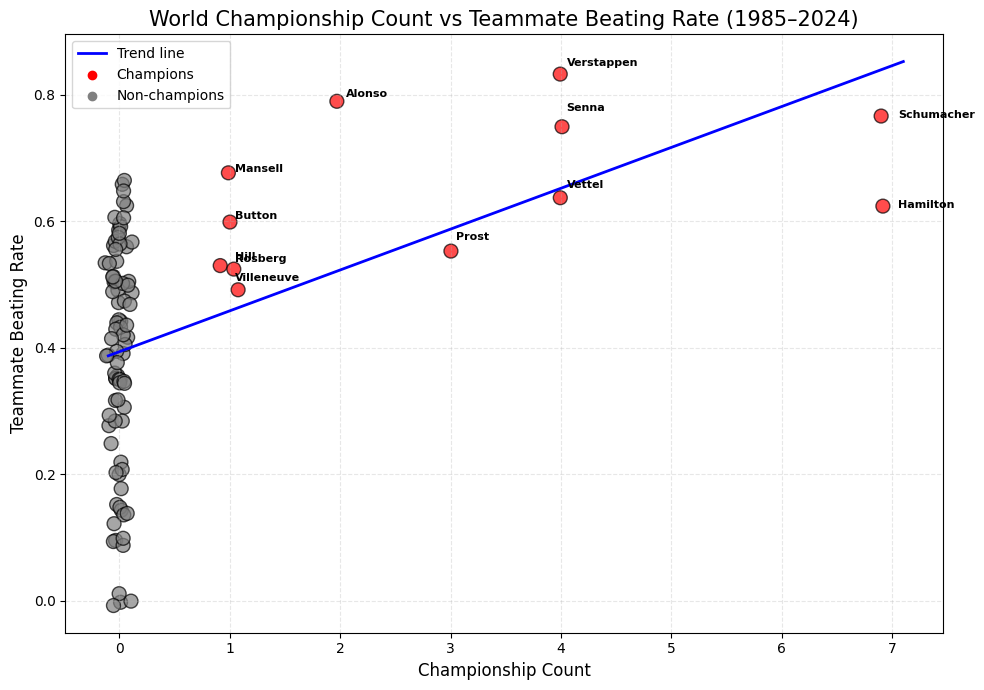

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("clean_teammate_beating_rate.csv")

df["full_name"] = df["forename"] + " " + df["surname"]

df["wc_count"] = df["full_name"].apply(lambda x: world_champions_1985_2024.get(x, 0))
# Filter noise
df_f = df[df["total_races"] >= 5].copy()
x = df_f["wc_count"]
y = df_f["beating_rate"]

# Add jitter
jitter_x = x + np.random.normal(0, 0.05, len(x))
jitter_y = y + np.random.normal(0, 0.01, len(y))

colors = ["red" if wc > 0 else "gray" for wc in df_f["wc_count"]]
plt.figure(figsize=(10,7))
plt.scatter(jitter_x, jitter_y, s=100, c=colors, alpha=0.7, edgecolor="black")
for _, row in df_f[df_f["wc_count"] > 0].iterrows():
    plt.text(
        row["wc_count"] + 0.05,
        row["beating_rate"] + 0.005,
        row["surname"],
        fontsize=8,
        fontweight='bold'
    )

# Regression line
m, b = np.polyfit(x, y, 1)
line_x = np.linspace(x.min()-0.1, x.max()+0.1, 100)

plt.plot(line_x, m*line_x + b, color="blue", linewidth=2, label="Trend line")
plt.title("World Championship Count vs Teammate Beating Rate (1985–2024)", fontsize=15)
plt.xlabel("Championship Count", fontsize=12)
plt.ylabel("Teammate Beating Rate", fontsize=12)
plt.scatter([], [], color="red", label="Champions")
plt.scatter([], [], color="gray", label="Non-champions")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Now I check whether there is a direct relationship among the champion groups so we can make sure that more championship means outperforming your teammate more.

In [175]:

# Keep only champions
champions = df[df["wc_count"] > 0].copy()

print("Number of champions in dataset:", len(champions))

# Extract arrays
titles = champions["wc_count"]
rates = champions["beating_rate"]

df = df[df["total_races"] >= 5]

spear_corr, spear_p = spearmanr(titles, rates)
df=11 #degrees of freedom is easier to compute since we have 12 champions -1 gives us degrees of freedom
print("\nChampion Only: Spearman Correlation")
print("Correlation:", spear_corr)
print("p-value:", spear_p)
print(f"df = 11")

Number of champions in dataset: 12

Champion Only: Spearman Correlation
Correlation: 0.5673204359309568
p-value: 0.05437915791282175
df = 11


In that case we can only apply Spearman Correlation test because we have only 1 group. We are simply calculating monotonic relationship between number of championships and beating your teammate more.

In this instance we had p_value almost as small as 0.05. I am guessing it is because between 1985-2024 there are only 12 champions. We cannot simply reject H₀ but we got something pretty close to being significant.

Visualising the data:

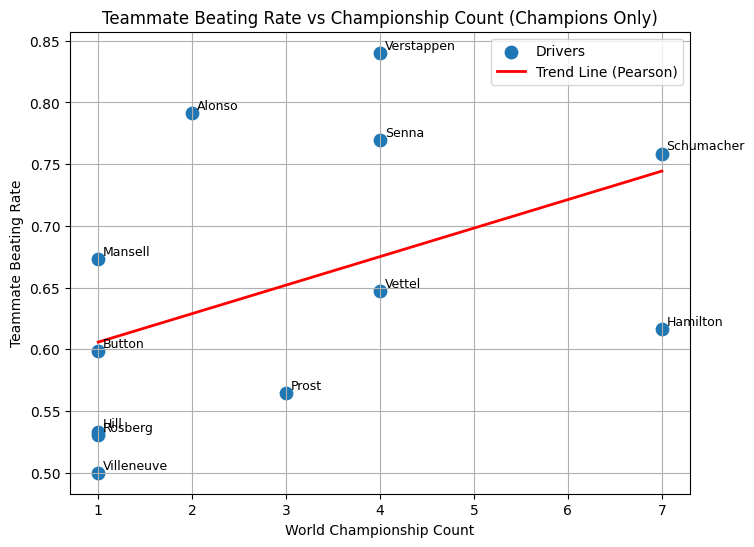

In [177]:
df = pd.read_csv("clean_teammate_beating_rate.csv")

df["full_name"] = df["forename"] + " " + df["surname"]
df["wc_count"] = df["full_name"].apply(lambda x: world_champions_1985_2024.get(x, 0))
# Keep only champions
champions = df[df["wc_count"] > 0].copy()


# Extract data
x = champions["wc_count"]
y = champions["beating_rate"]

plt.figure(figsize=(8,6))

# Scatter plot
plt.scatter(x, y, s=80, label="Drivers")

# Annotate surnames
for _, row in champions.iterrows():
    plt.text(
        row["wc_count"] + 0.05,
        row["beating_rate"] + 0.003,
        row["surname"],
        fontsize=9
    )

# Fit a line y = m*x + b
m, b = np.polyfit(x, y, 1)

# Generate line points
x_line = np.linspace(x.min(), x.max(), 100)
y_line = m * x_line + b

plt.plot(x_line, y_line, color="red", linewidth=2, label="Trend Line (Pearson)")

# Labels & formatting
plt.xlabel("World Championship Count")
plt.ylabel("Teammate Beating Rate")
plt.title("Teammate Beating Rate vs Championship Count (Champions Only)")
plt.grid(True)
plt.legend()

plt.show()


**From here we are checking for second hypothesis. We will be searching for a relationship between rain race win rate and being a champion. Since we already merged data in the first hypothesis we simply start by applying tests.**

Wet Win Rate vs World Championships
Spearman r = 0.6158, p = 0.000000

 T-TEST: Champions vs Non-Champions (Wet Win Rate)
t = 3.1642, p = 0.008117


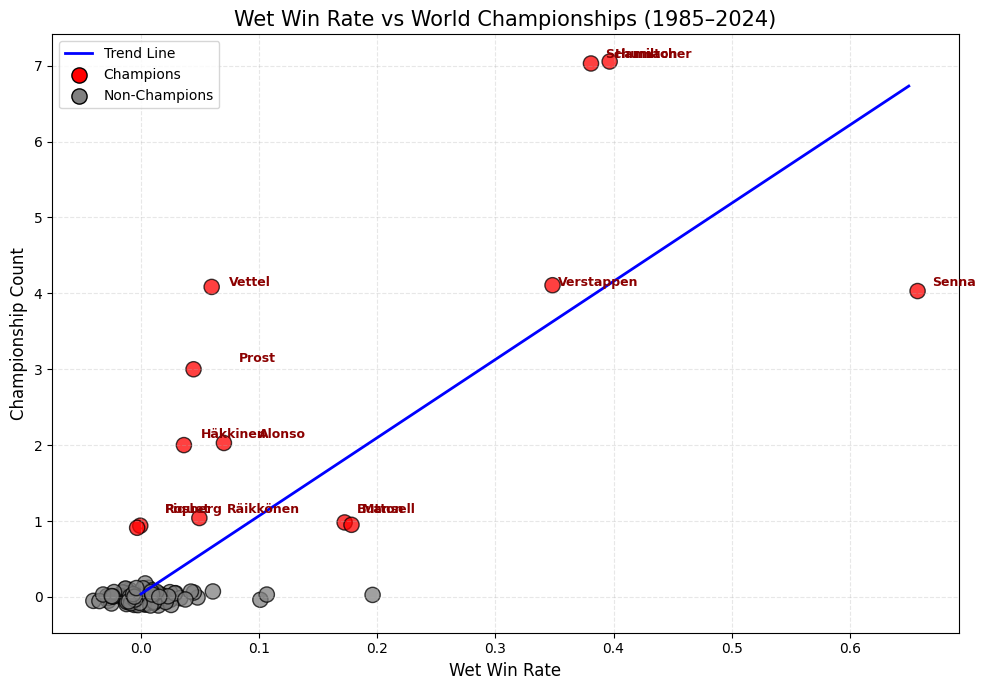

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, ttest_ind

df = pd.read_csv("driver_finishing_positions.csv")

df["raceId"] = pd.to_numeric(df["raceId"], errors="coerce")
df["is_win"] = df["positionText"].astype(str).apply(lambda x: 1 if x == "1" else 0)
df["is_wet"] = df["is_true_wet"].astype(int)
df["fullname"] = df["forename"] + " " + df["surname"]

# Total wet races entered for each driver
wet_races = (
    df[df["is_wet"] == 1]
    .groupby("driverId")
    .size()
    .reset_index(name="wet_races")
)

# Wet wins
wet_wins = (
    df[(df["is_wet"] == 1) & (df["is_win"] == 1)]
    .groupby("driverId")
    .size()
    .reset_index(name="wet_wins")
)

# Merge
wet_stats = wet_races.merge(wet_wins, on="driverId", how="left")
wet_stats["wet_wins"] = wet_stats["wet_wins"].fillna(0)

names = df[["driverId", "fullname", "surname"]].drop_duplicates()
wet_stats = wet_stats.merge(names, on="driverId", how="left")

wet_stats["wet_win_rate"] = wet_stats["wet_wins"] / wet_stats["wet_races"]

# Filter drivers with less than 5 races for clearing noise
wet_stats = wet_stats[wet_stats["wet_races"] >= 5]

wdc = {
    "Alain Prost": 3,
    "Nelson Piquet": 1,
    "Nigel Mansell": 1,
    "Ayrton Senna": 4,
    "Michael Schumacher": 7,
    "Mika Häkkinen": 2,
    "Fernando Alonso": 2,
    "Kimi Räikkönen": 1,
    "Lewis Hamilton": 7,
    "Jenson Button": 1,
    "Sebastian Vettel": 4,
    "Nico Rosberg": 1,
    "Max Verstappen": 4,
}

wet_stats["wc_count"] = wet_stats["fullname"].apply(lambda x: wdc.get(x, 0))

x = wet_stats["wet_win_rate"]
y = wet_stats["wc_count"]

spear_r, spear_p = spearmanr(x, y)
kend_r, kend_p = kendalltau(x, y)

print("Wet Win Rate vs World Championships")
print(f"Spearman r = {spear_r:.4f}, p = {spear_p:.6f}")

#applying t test
champ = wet_stats[wet_stats["wc_count"] > 0]["wet_win_rate"]
nonchamp = wet_stats[wet_stats["wc_count"] == 0]["wet_win_rate"]

t_stat, p_val = ttest_ind(champ, nonchamp, equal_var=False)

print("\n T-TEST: Champions vs Non-Champions (Wet Win Rate)")
print(f"t = {t_stat:.4f}, p = {p_val:.6f}")


plt.figure(figsize=(10,7))

# JITTER SETTINGS
jitter_strength_x = 0.015
jitter_strength_y = 0.05

# Apply jitter
jitter_x = x + np.random.normal(0, jitter_strength_x, len(x))
jitter_y = y + np.random.normal(0, jitter_strength_y, len(y))

# Color champions vs non-champions
colors = ["red" if wc > 0 else "gray" for wc in wet_stats["wc_count"]]

# Scatter plot
plt.scatter(jitter_x, jitter_y, s=120, c=colors, alpha=0.75, edgecolor="black")

# Label champions only
champions = wet_stats[wet_stats["wc_count"] > 0]
for _, row in champions.iterrows():
    plt.text(
        row["wet_win_rate"] + 0.02,
        row["wc_count"] + 0.1,
        row["surname"],
        fontsize=9,
        fontweight="bold",
        color="darkred"
    )

# Regression line
m, b = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
plt.plot(line_x, m * line_x + b, color="blue", linewidth=2, label="Trend Line")

# Titles / labels
plt.title("Wet Win Rate vs World Championships (1985–2024)", fontsize=15)
plt.xlabel("Wet Win Rate", fontsize=12)
plt.ylabel("Championship Count", fontsize=12)

# Legend
plt.scatter([], [], s=120, color="red", edgecolor="black", label="Champions")
plt.scatter([], [], s=120, color="gray", edgecolor="black", label="Non-Champions")
plt.legend()

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

As it can seen both by tests and visual data we have found pretty good relationship here. Again we also left out if a driver has less than 5 wet races.

Spearman again telling us here whether there is a relationship between being a champion and winning in wet races more in a monotonic fashion. And we found p_value that is intensely smaller than 0.05 so it tells us that our findings are significant.

In T-test we are comparing the average of winning more in wet races of champions and non-champions. Again we have a p_value smaller than 0.05 so our findings here are significant.

We can reject H₀ since p_values support our alternative hypothesis.

Wet Win Rate vs Championships (Champions Only)
Spearman r = 0.6595, p = 0.0142


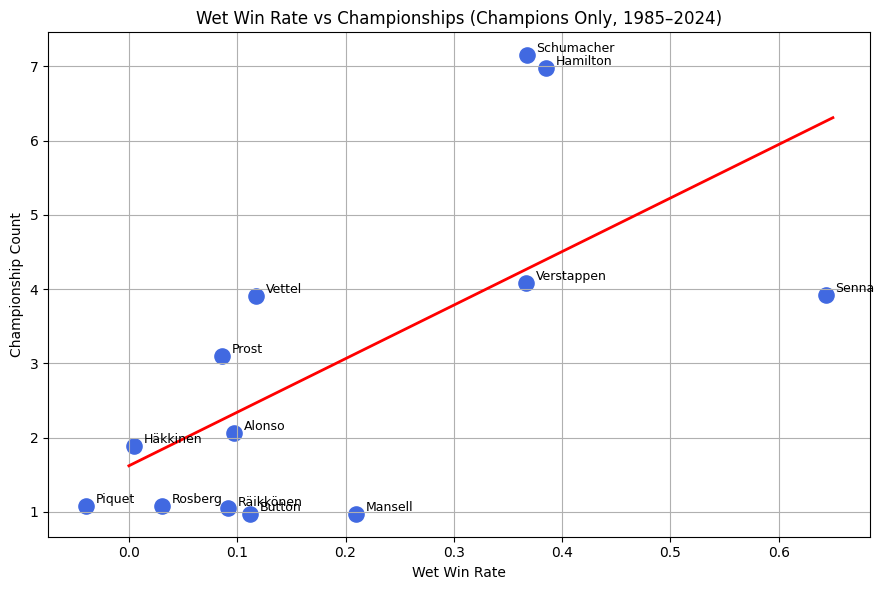

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# FILTER ONLY WORLD CHAMPIONS
champ_only = wet_stats[wet_stats["wc_count"] > 0].copy()

x = champ_only["wet_win_rate"]
y = champ_only["wc_count"]

# APPLY JITTERING
jitter_x = x + np.random.normal(0, 0.03, size=len(x))
jitter_y = y + np.random.normal(0, 0.07, size=len(y))

spear_r, spear_p = spearmanr(x, y)
tau, p = kendalltau(wet_stats["wet_win_rate"], wet_stats["wc_count"])
print("Wet Win Rate vs Championships (Champions Only)")
print(f"Spearman r = {spear_r:.4f}, p = {spear_p:.4f}")



plt.figure(figsize=(9,6))
plt.scatter(jitter_x, jitter_y, s=120, color="royalblue")
for jx, jy, name in zip(jitter_x, jitter_y, champ_only["surname"]):
    plt.text(jx + 0.009, jy + 0.04, name, fontsize=9)

# Trend line (use REAL x, y — not jittered)
m, b = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
plt.plot(line_x, m*line_x + b, color="red", linewidth=2)

plt.xlabel("Wet Win Rate")
plt.ylabel("Championship Count")
plt.title("Wet Win Rate vs Championships (Champions Only, 1985–2024)")
plt.grid(True)
plt.tight_layout()
plt.show()


I applied jittering here so it can be more visible.

With Spearman we are checking whether there if more number of championships meant more wet win rate monotonically. We had p_value lower than 0.05 so our findings suggest that there is a significant relationship.

Basically test tells us there is a significant relationship between number of championship won and wet win rate. Basically all three p_values are smaller than 0.05 so we simply reject H₀.